### Imports

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation

### Plotting Functions

In [31]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signal_components(signal, start_time, end_time, scale=(None, None), fft_size=128, sample_rate=3*1e+8, title="", size=(6, 12)):
    t = np.linspace(start_time, end_time, signal.shape[0])
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(size[1], size[0]))
    ax1.plot(t, signal.imag, linewidth=0.75, label='Imaginary Part', color="red")
    ax1.plot(t, signal.real, linewidth=0.75, label='Real Part', color="darkblue")
    ax1.set_title(title)
    ax1.set_xlabel("Time (us)")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="lower right")
    ax1.grid(True)
    ax1.set_xlim([t[0], t[-1]])
    if scale is not None:
        ax2.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='jet', vmin=scale[0], vmax=scale[1])
    else:
        ax2.specgram(signal, NFFT=fft_size, Fs=sample_rate, noverlap=fft_size-1, cmap='jet')
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Frequency")
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)
    plt.show()

def norm_log(signal, weight=20):
    norm = np.abs(signal) / np.max(np.abs(signal))
    return weight * np.log10(norm)

### Saving Function

In [3]:
def save_to_cf32(data: np.ndarray, filename: str):
    if not np.iscomplexobj(data):
        raise ValueError("Input data must be a complex numpy array.")
    interleaved_data = np.empty(2 * len(data), dtype=np.float32)
    interleaved_data[0::2] = data.real.astype(np.float32)
    interleaved_data[1::2] = data.imag.astype(np.float32)
    interleaved_data.tofile(filename)

### Processing Functions

In [4]:
range_decimation_list = [
    112.6041667, 100.0925926, 0.000000000, 83.41049387,
    66.72839509, 56.30208336, 50.04629632, 25.02314816,
    64.34523813, 46.91840280, 17.32371796, 54.59595962
]

def get_replica_chirp(packet):
    secondary_header = packet.get_secondary_header()
    range_decimation = secondary_header['range_decimation']
    txpsf = secondary_header['tx_pulse_start_frequency']
    txprr = secondary_header['tx_ramp_rate']
    txpl  = secondary_header['pulse_length']
    phi_1 = txpsf
    phi_2 = txprr / 2
    fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
    t = np.linspace(0.0, txpl, fs)
    chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
    return chirp

def get_reference_function(replica, ref_samples):
    rep_samples = replica.shape[0]
    ref_func = np.zeros(ref_samples, dtype=complex)
    ref_func[0:rep_samples] = replica
    window = np.hanning(ref_samples)
    reference = np.conj(ref_func) * window
    norm = np.abs(reference)
    energy = 0.0
    for i in range(ref_samples):
        energy += (norm[i] * norm[i])
    energy /= ref_samples
    for i in range(ref_samples):
        reference[i] = reference[i] / energy
    return np.asarray(reference)

def pulse_compression(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_samples = chirp.shape[0]
    ref_func = get_reference_function(replica, ref_samples)
    f_ref_func = fft(ref_func)
    for i in range(ref_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifft(np.asarray(pulse_compressed))

def get_nth_packet(filename, n):
    raw_data = open(filename, 'rb')
    PacketGenerator = packet_generator(raw_data)
    packet = None
    index = 0
    while index <= n:
        packet = next(PacketGenerator)
        index += 1
    return packet

### Get Signals

In [18]:
filename = '../../sentinel1_decode/data/sample/sample.dat'

packet = get_nth_packet(filename, 0)

signal = packet.get_complex_samples()[0]
replica = get_replica_chirp(packet)
compressed = pulse_compression(signal, replica)

packet_header = packet.get_secondary_header()

sampling_window_length = packet_header["swl"] * 10e-6
pulse_length = packet_header["pulse_length"] * 10e-6
fft_size = 128
sample_rate = signal.shape[0] / sampling_window_length

### Plot Signals

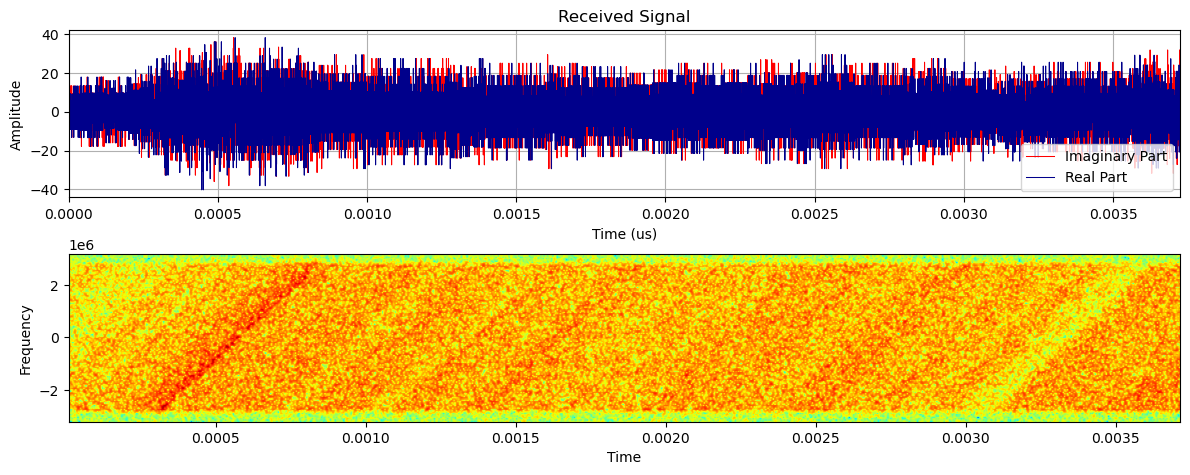

In [32]:
plot_signal_components(signal, 0, sampling_window_length, scale=(-110, -25), fft_size=fft_size, sample_rate=sample_rate, title="Received Signal")

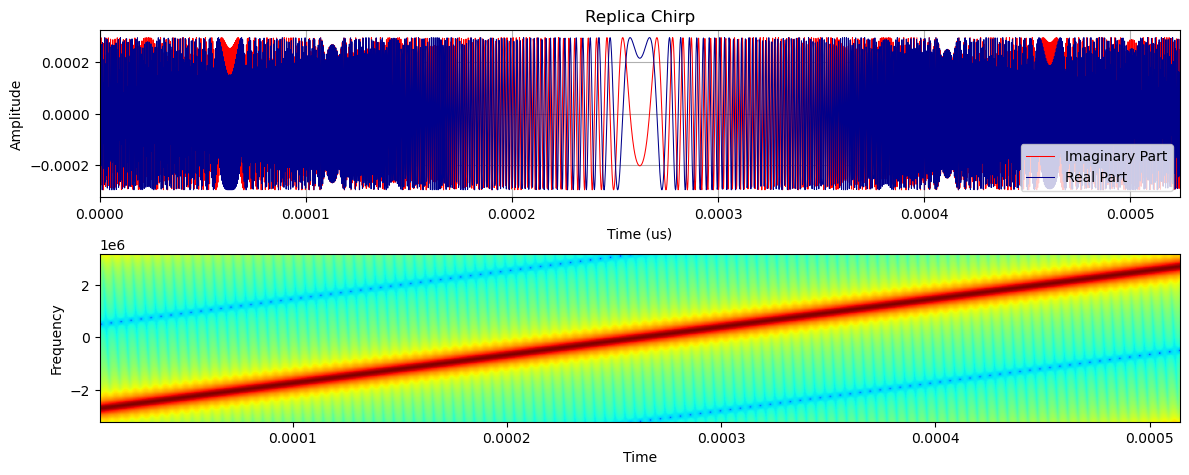

In [34]:
plot_signal_components(replica, 0, pulse_length, fft_size=fft_size, sample_rate=(replica.shape[0]/pulse_length), title="Replica Chirp")

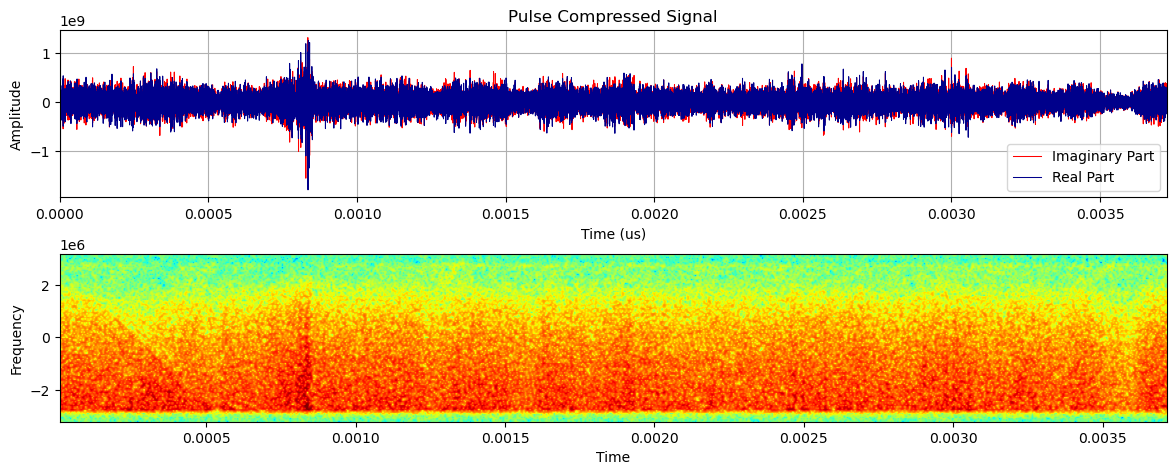

In [35]:
plot_signal_components(compressed, 0, sampling_window_length, scale=(10, 120), fft_size=fft_size, sample_rate=sample_rate, title="Pulse Compressed Signal")

### Save Signals

In [9]:
save_to_cf32(signal, 'signal.cf32')
save_to_cf32(replica, 'replica.cf32')
save_to_cf32(compressed, 'compressed.cf32')

In [10]:
packet

Packet Type: D
--------------

Primary Header:
---------------
Packet Version Number: 0
Packet Type: 0
Secondary Header Flag: 1
Process ID: 65
Process Category: 12
Packet Sequence Count: 11157
Packet Data Length: 18621

Secondary Header:
-----------------
Coarse Time: 1406987562
Fine Time: 7757
Sync Marker: 892270675
Data Take ID: 225252800
Sensor Mode: interferomatric_wide_swath
Test Mode: measurement_mode
RX Channel ID: V
Instrument Configuration ID: 7
Sub-Commutative Word Index: 27
Sub-Commutative Word: 1011111011000011
Space Packet Count: 240533
PRI Count: 243384
Error Flag: nominal
BAQ Mode: fdbaq_mode_0
BAQ Block Length: 256
Range Decimation: 8
RX Gain: -4.0
TX Ramp Rate: 1.078230321255918
Pulse Start Frequency: -28.251534196373175
Pulse Length: 52.40481033595628
Rank: 9
PRI: 582.3674372819869
SWST: 98.06919514319017
SWL: 372.4284919605149
SSB Flag: 0
Polarisation: V
Temperature Compensation: 3
Elevation Beam Address: 6
Azimuth Beam Address: 385
Calibration Mode: 0
TX Pulse Numbe